In [1]:
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SRCNN(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(base_channels, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, in_channels, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)


In [7]:
def calculate_psnr(sr, hr):
    mse = F.mse_loss(sr, hr)
    psnr = -10 * torch.log10(mse)
    return psnr

class SRCNNLightningModule(pl.LightningModule):
    def __init__(self, lr=1e-4, scale=2, in_channels=3):
        super().__init__()
        self.model = SRCNN(in_channels=in_channels)
        self.loss_fn = torch.nn.L1Loss()
        self.lr = lr
        self.scale = scale

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale, mode='bicubic')
        return self.model(x)

    def training_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self.forward(lr)
        loss = self.loss_fn(sr, hr)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        lr, hr = batch
        sr = self.forward(lr)
        loss = self.loss_fn(sr, hr)
        psnr = calculate_psnr(sr, hr)
        self.log('val_loss', loss)
        self.log('val_psnr', psnr)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [8]:
checkpoint = torch.load('../logs/srcnn_lightning_Ychannel/version_1/checkpoints/epoch=49-step=2500.ckpt')
model = SRCNNLightningModule(lr=1e-4, scale=3, in_channels=1)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

SRCNNLightningModule(
  (model): SRCNN(
    (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (loss_fn): L1Loss()
)

In [17]:
img_LR = np.array(Image.open('/Network/Servers/fs.local/Volumes/home/kawai/nas/Document/workspace/sr_projects/srcnn_lightning/data/Set14/image_SRF_4/img_005_SRF_4_LR.png').convert('YCbCr'))
img_HR = np.array(Image.open('/Network/Servers/fs.local/Volumes/home/kawai/nas/Document/workspace/sr_projects/srcnn_lightning/data/Set14/image_SRF_4/img_005_SRF_4_HR.png').convert('RGB'))

img_LR_tensor = torch.tensor(img_LR).permute(2, 0, 1).unsqueeze(0).float() / 255.0
img_LR_tensor_Y = img_LR_tensor[:, 0:1, :, :]  # Y channel
img_LR_tensor_Cb = F.interpolate(img_LR_tensor[:, 1:2, :, :], scale_factor=3, mode='bicubic')
img_LR_tensor_Cr = F.interpolate(img_LR_tensor[:, 2:3, :, :], scale_factor=3, mode='bicubic')

img_HR_tensor = torch.tensor(img_HR).permute(2, 0, 1).unsqueeze(0).float() / 255.0

img_SR_tensor_Y = model(img_LR_tensor_Y.clamp(0,1))
img_SR_tensor = torch.cat((img_SR_tensor_Y.clamp(0,1), img_LR_tensor_Cb.clamp(0,1), img_LR_tensor_Cr.clamp(0,1)), dim=1)

img_bicubic_tensor = F.interpolate(img_LR_tensor, scale_factor=3, mode='bicubic')

In [23]:
bicubic = img_bicubic_tensor.squeeze(0).permute(1, 2, 0).clamp(0,1).detach().numpy()
bicubic_rgb = Image.fromarray((bicubic * 255).astype(np.uint8), mode='YCbCr')
bicubic_rgb = np.array(bicubic_rgb.convert('RGB'))

In [27]:
def show_images(lr, hr, sr):
    """Display LR and HR images side by side."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(lr.permute(1, 2, 0).numpy(), )
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr.permute(1, 2, 0).numpy())
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')
    
    axes[2].imshow(sr.permute(1, 2, 0).detach().numpy())
    axes[2].set_title('Super Resolution Image')
    axes[2].axis('off')

    plt.show()

def show_images_numpy(lr, hr, sr):
    """Display LR and HR images side by side using numpy arrays."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(lr)
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr)
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')
    
    axes[2].imshow(sr)
    axes[2].set_title('Super Resolution Image')
    axes[2].axis('off')

    plt.show()

def show_img_panel_numpy(lr, hr, sr, bicubic):
    """Display LR, HR, SR, and Bicubic images side by side using numpy arrays."""
    fig, axes = plt.subplots(1, 4, figsize=(16, 6))
    axes[0].imshow(lr)
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr)
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')
    
    axes[2].imshow(sr)
    axes[2].set_title('Super Resolution Image')
    axes[2].axis('off')

    axes[3].imshow(bicubic)
    axes[3].set_title('Bicubic Interpolation')
    axes[3].axis('off')

    plt.show()

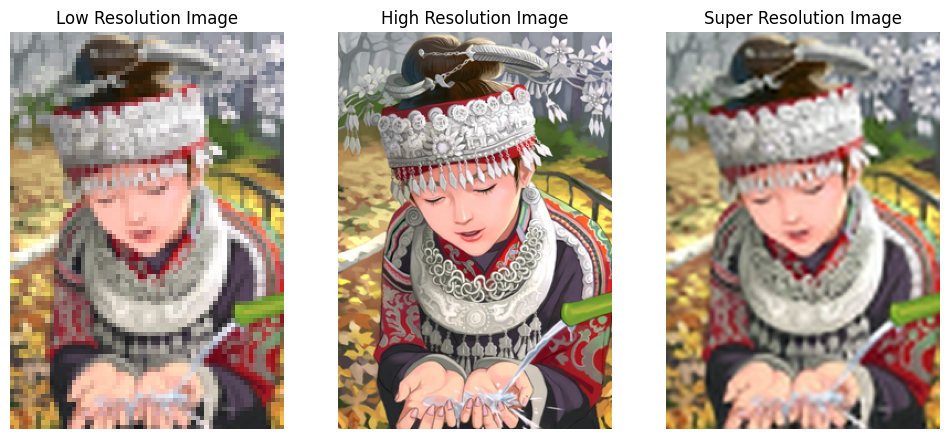

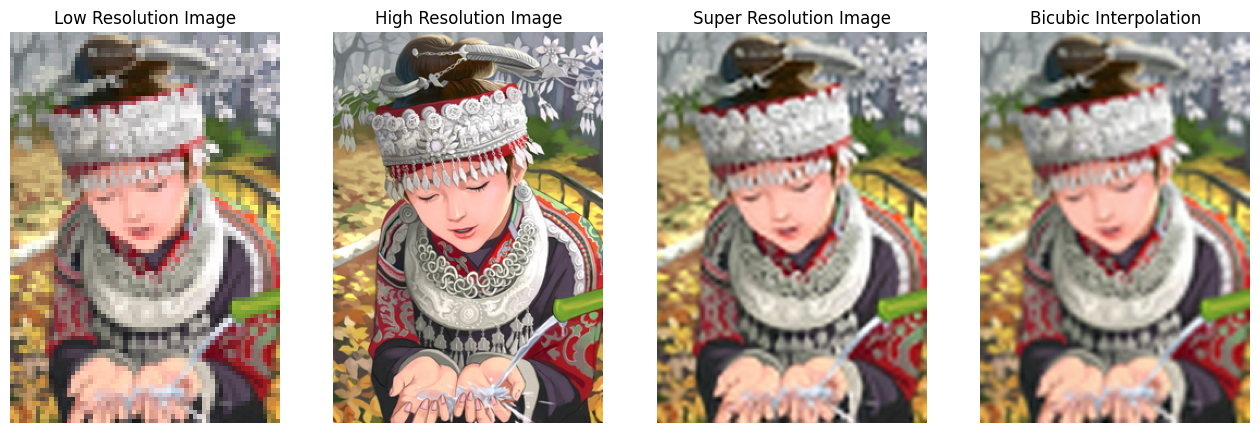

In [28]:
LR = np.array(Image.open('/Network/Servers/fs.local/Volumes/home/kawai/nas/Document/workspace/sr_projects/srcnn_lightning/data/Set14/image_SRF_4/img_005_SRF_4_LR.png').convert('RGB'))
SR = Image.fromarray((img_SR_tensor.squeeze(0).permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8), mode='YCbCr')
SR = np.array(SR.convert('RGB'))
show_images_numpy(LR, np.array(img_HR), SR)
show_img_panel_numpy(LR, np.array(img_HR), SR, bicubic_rgb)

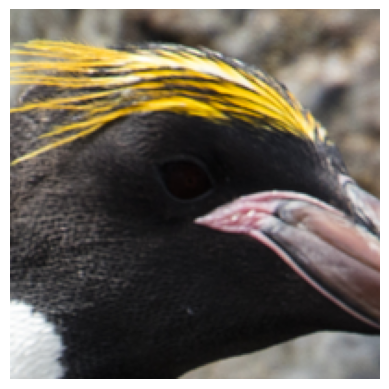

In [ ]:
patch = img_HR[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

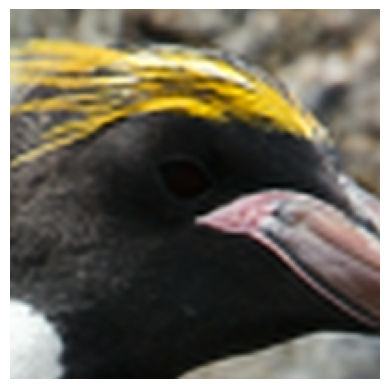

In [14]:
patch = SR[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

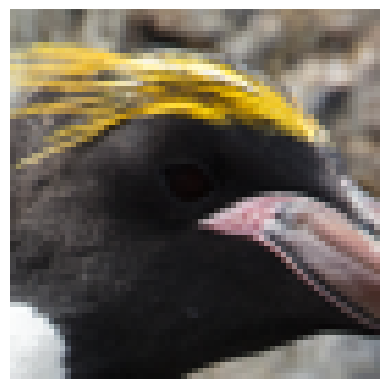

In [15]:
patch = LR[200//3:400//3, 800//3:1000//3, :]
plt.imshow(patch)
plt.axis('off')
plt.show()

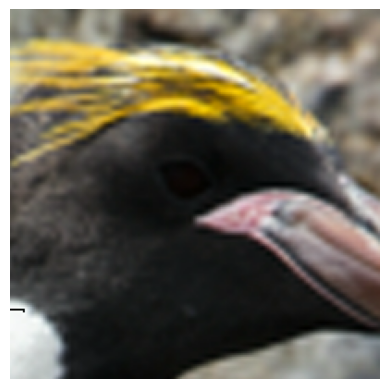

In [16]:
bicubic = img_bicubic_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
bicubic_rgb = Image.fromarray((bicubic * 255).astype(np.uint8), mode='YCbCr')
bicubic_rgb = np.array(bicubic_rgb.convert('RGB'))
patch = bicubic_rgb[200:400, 800:1000, :]
plt.imshow(patch)
plt.axis('off')
plt.show()